# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from termcolor import colored

# Load Coin Dataset

Set directories based on environment

In [2]:
# >>>> google colab <<<<
# from google.colab import drive
# drive.mount('/content/drive')
# base_dir = '/content/drive/MyDrive/coin_classifier/'

# >>>> local <<<<
base_dir = '.'

dataset_dir = '%s/images/obv_rev_images/' % base_dir
model_dir = '%s/saved_models/coin_side_classifier/' % base_dir
tflite_dir = '%s/saved_models/coin_side_classifier.tflite' % base_dir
labels_dir = '%s/labels/coin_side_labels.txt' % base_dir

Create training and validation data generators

In [12]:
batch_size = 128
img_dim = 128
img_shape = (img_dim, img_dim, 3)

labels = open(labels_dir).readlines()
labels = list(map(lambda x: x.strip(), labels))

zoom_layer = layers.RandomZoom((0, 0.2))
zoom = lambda x: zoom_layer(x)

datagen = preprocessing.image.ImageDataGenerator(
  rotation_range=40,
  width_shift_range=0.1,
  height_shift_range=0.1,
  brightness_range=(0.6, 1.4),
  preprocessing_function=zoom,
  validation_split=0.2,
  rescale=1./255
)

train_generator = datagen.flow_from_directory(
  dataset_dir,
  target_size=(img_dim, img_dim),
  batch_size=batch_size,
  class_mode='binary',
  interpolation='box',
  subset='training',
)
val_generator = datagen.flow_from_directory(
  dataset_dir,
  target_size=(img_dim, img_dim),
  batch_size=batch_size,
  class_mode='binary',
  interpolation='box',
  subset='validation',
)

Found 3286 images belonging to 2 classes.
Found 820 images belonging to 2 classes.


Display coin images

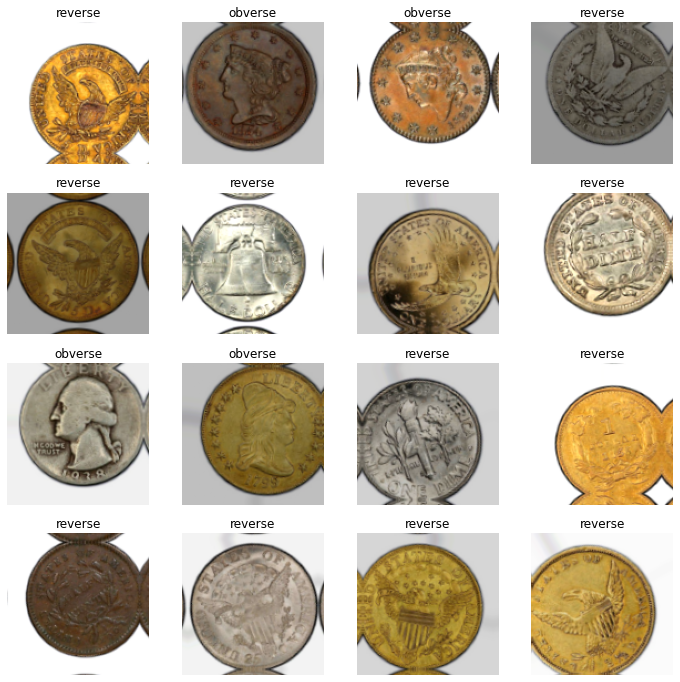

In [13]:
fig = plt.figure(figsize=(12, 12))
X_batch, y_batch = train_generator.next()
for i in range(min(len(X_batch), 16)):
  fig.add_subplot(4, 4, i + 1)
  plt.imshow(X_batch[i])
  plt.axis('off')
  plt.title(labels[int(y_batch[i])])

# Create and Train CNN

In [14]:
coin_classifier = models.Sequential([
  layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', input_shape=img_shape),
  layers.MaxPooling2D(pool_size=2),
  
  layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
  layers.MaxPooling2D(pool_size=2),

  layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
  layers.MaxPooling2D(pool_size=2),

  layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
  layers.MaxPooling2D(pool_size=2),

  layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
  layers.MaxPooling2D(pool_size=2),

  # layers.Conv2D(filters=1024, kernel_size=3, activation='relu', padding='same'),
  # layers.MaxPooling2D(pool_size=2),

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(1, activation='sigmoid'),
])
coin_classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)      

In [15]:
coin_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = coin_classifier.fit(train_generator, validation_data=val_generator, epochs=25)

2021-12-03 11:56:33.532146: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
26/26 [==============================] - 58s 2s/step - loss: 0.6953 - accuracy: 0.5070 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/25
26/26 [==============================] - 52s 2s/step - loss: 0.6932 - accuracy: 0.4912 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/25
26/26 [==============================] - 52s 2s/step - loss: 0.6933 - accuracy: 0.4915 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/25
26/26 [==============================] - 52s 2s/step - loss: 0.6933 - accuracy: 0.4954 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/25
26/26 [==============================] - 52s 2s/step - loss: 0.6931 - accuracy: 0.5134 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/25
26/26 [==============================] - 52s 2s/step - loss: 0.6931 - accuracy: 0.5155 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/25
26/26 [==============================] - 53s 2s/step - loss: 0.6932 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 8/25
15/26 [==

KeyboardInterrupt: 

Plot training and validation accuracies

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['obv_train', 'obv_val'])
plt.show()

# Save/Load Model:

Save model

In [ ]:
model.save(model_dir)

Save model using tflite format

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(model_dir)
tflite_model = converter.convert()
with open(tflite_dir, 'wb') as f:
  f.write(tflite_model)

Load model

In [ ]:
model = models.load_model(model_dir)

Load tflite model

In [ ]:
interpreter = tf.lite.Interpreter(tflite_dir)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test Images:

Calculate class accuracies for validation set

In [ ]:
from collections import Counter

correct = Counter()
total = Counter()

predictions = {}
for i in range(len(labels)):
  predictions[i] = Counter()

batches = [val_generator.next() for _ in range(len(val_generator))]

for X, y in batches:
  preds = [np.argmax(pred) for pred in model.predict(X)]
  for i, pred in enumerate(preds):
    true = np.argmax(y[i])
    predictions[true][pred] += 1
    if true == pred:
      correct[true] += 1
    total[true] += 1

In [ ]:
running_count = 0
running_total = 0
for label, count in sorted(correct.items(), key=lambda x: x[1] / total[x[0]], reverse=True):
  accuracy = count / total[label]
  running_count += count
  running_total += total[label]
  pred_list = sorted(list(predictions[label].items()), key=lambda x: x[1], reverse=True)
  pred_list = [(labels[pred[0]], pred[1]) for pred in pred_list]
  print('==== %s ====' % labels[label])
  print('Accuracy: %.2f%%' % (accuracy * 100))
  print(pred_list)
  print()
print('Overall Accuracy: %.2f%%' % ((running_count / running_total) * 100))

Test custom images

In [ ]:
fig = plt.figure(figsize=(20, 20))
X_batch, y_batch = val_generator.next()
predictions = model.predict(X_batch)
for i in range(min(len(X_batch), 64)):
  fig.add_subplot(8, 8, i + 1)
  plt.imshow(X_batch[i])
  plt.axis('off')
  title_obj = plt.title(labels[np.argmax(predictions[i])])
  plt.setp(title_obj, color='g' if np.argmax(predictions[i]) == np.argmax(y_batch[i]) else 'r')

In [ ]:
def load_img(img_name):
  img = Image.open('%s/test_images/%s' % (base_dir, img_name))
  img = img.resize(size=(img_size[0], img_size[1]))
  img_data = np.divide(preprocessing.image.img_to_array(img), 255.0)
  return img_data, img_name.split('-')[0]

def predict(img_data, using_tflite=False):
  if using_tflite:
    interpreter.set_tensor(input_details[0]['index'], [img_data])
    interpreter.invoke()
    return interpreter.get_tensor(output_details[0]['index'])[0]
  else:
    return model.predict(tf.data.Dataset.from_tensors([img_data]))[0]

def get_color(prediction, true, index):
  if index == -1:
    return 'green' if prediction == true else 'red'
  else:
    return 'yellow' if prediction == true else 'white'

In [ ]:
img_data, label = load_img('three_cent_nickel-r.jpg')
prediction = predict(img_data)
ranked = np.argsort(prediction)

prediction_sorted = sorted(prediction)

for i in range(-1,-6,-1):
  print(colored('%d: %.2f%% %s' % (abs(i), prediction_sorted[i] * 100, labels[ranked[i]]), get_color(labels[ranked[i]], label, i)))

plt.title(labels[np.argmax(prediction)])
plt.axis('off')
plt.imshow(img_data)